# Kanji Radical Match

Loading data, training, and output.

In [1]:
import utils as u
import torch.nn as nn
import torch
from utils import KanjiFFNN
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# eng_to_rads = u.load_eng_to_rads()
eng_to_rads = u.json_to_dict('./data/english_to_radicals.json')
eng_tens, rad_tens, eng_vocab, rad_vocab = u.dict_to_tensors(eng_to_rads)

In [3]:
print("Vocabulary size:", len(eng_vocab))
print("Radical vocabulary size:", len(rad_vocab))

Vocabulary size: 12091
Radical vocabulary size: 253


In [4]:
# Print a small sample of our data
print(eng_tens[:5])
print(eng_vocab[:5])
print(rad_tens[:5])
print(rad_vocab[:5])

tensor([8091, 8614, 8501, 6902, 6810])
['to hide', 'put on (a sword)', 'tall (7 chi) horse', 'take hold of', 'twang']
tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['土', '阡', '弋', '臣', '虫']


In [5]:
# Example
print(u.get_tensor_from_word("eight", eng_tens, eng_vocab, rad_vocab, eng_to_rads))
print(len(u.get_tensor_from_word("eight", eng_tens, eng_vocab, rad_vocab, eng_to_rads)))

tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [7]:
e2r_model = KanjiFFNN(eng_tens.size(0), rad_tens.size(-1))
criterion = nn.BCELoss()
optimizer = optim.Adam(e2r_model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
e2r_model.eval()

KanjiFFNN(
  (embedding): Embedding(12091, 253)
  (hid1): Linear(in_features=253, out_features=253, bias=True)
  (output): Linear(in_features=253, out_features=253, bias=True)
)

In [ ]:
epochs = 10

history = e2r_model.train_fit(eng_tens, rad_tens, optimizer, criterion, epochs=epochs, scheduler=lr_scheduler, verbose=True)

In [14]:
torch.save(e2r_model, "./models/model_v3.pt")

In [15]:
torch.save(e2r_model.state_dict(), "./models/model_v3_state_dict.pt")

In [11]:
loaded_model = KanjiFFNN(eng_tens.size(1), rad_tens.size(1))
loaded_model.load_state_dict(torch.load("./models/model_v3_state_dict.pt"))
loaded_model.eval()

KanjiFFNN(
  (input): Linear(in_features=12531, out_features=253, bias=True)
  (hid1): Linear(in_features=253, out_features=253, bias=True)
  (output): Linear(in_features=253, out_features=253, bias=True)
)

In [16]:
# For direct usage
loaded_model = e2r_model

In [17]:
input_word = "eight"
test_tensor = u.get_tensor_from_word(input_word, eng_tens, eng_vocab)
res = loaded_model(test_tensor)
print(res)

tensor([1.2716e-02, 2.8683e-02, 1.5721e-05, 1.2777e-03, 5.5756e-04, 1.5856e-03,
        1.8050e-04, 1.8680e-02, 4.3195e-03, 2.1837e-06, 8.1963e-09, 1.8731e-04,
        3.8985e-04, 9.9292e-03, 2.8122e-06, 2.7945e-08, 5.1652e-03, 3.4968e-02,
        2.6292e-06, 2.5396e-03, 9.3676e-03, 1.2435e-05, 7.3588e-03, 4.8023e-02,
        6.2091e-05, 3.6633e-07, 1.1384e-04, 6.8667e-03, 4.9442e-09, 1.8881e-03,
        7.9519e-04, 1.5765e-05, 1.3855e-04, 5.8560e-02, 1.8741e-02, 9.6796e-03,
        1.2305e-02, 7.0806e-02, 3.6846e-04, 2.2010e-03, 6.1990e-02, 7.6004e-03,
        8.2093e-02, 2.7543e-03, 6.1998e-02, 3.8895e-03, 1.5152e-01, 3.7157e-03,
        3.4133e-07, 1.8592e-01, 1.7340e-03, 3.3960e-02, 3.1435e-02, 2.4364e-03,
        3.4927e-02, 8.0604e-05, 2.0098e-02, 1.0988e-08, 7.5476e-03, 4.1730e-03,
        2.2923e-02, 1.0653e-01, 3.4783e-04, 3.4454e-02, 1.2893e-08, 6.8092e-08,
        2.1335e-03, 8.7069e-06, 3.2178e-06, 5.8649e-03, 7.0892e-08, 3.5669e-04,
        1.8180e-03, 9.8323e-03, 2.2394e-

In [18]:
output_probs = res.detach().numpy().squeeze()
radical_probs = [(radical, prob) for radical, prob in zip(rad_vocab, output_probs)]
sorted_radical_probs = sorted(radical_probs, key=lambda x: x[1], reverse=True)
print(sorted_radical_probs[:15])

[('日', 0.33916727), ('口', 0.18592213), ('田', 0.16987702), ('厶', 0.15151873), ('寸', 0.106525786), ('十', 0.08209308), ('木', 0.07180098), ('勹', 0.07080649), ('卩', 0.061998203), ('化', 0.061989505), ('刀', 0.05855971), ('心', 0.051430363), ('戈', 0.049958073), ('儿', 0.04802336), ('扎', 0.0469169)]


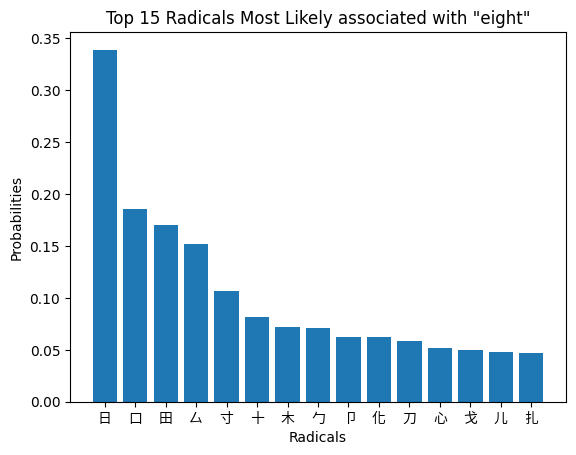

In [19]:
TOP_TAKE = 15
fprop = fm.FontProperties(fname='NotoSansCJKtc-Regular.otf')

radicals, probabilities = zip(*sorted_radical_probs)

radicals_top = list(radicals[:TOP_TAKE])
probabilities_top = list(probabilities[:TOP_TAKE])

fig, axs = plt.subplots()
axs.bar(range(TOP_TAKE), probabilities_top)
axs.set_xticks(range(TOP_TAKE), radicals_top, fontproperties=fprop)
axs.set_xlabel('Radicals')
axs.set_ylabel('Probabilities')
axs.set_title(f'Top {TOP_TAKE} Radicals Most Likely associated with \"{input_word}\"')

plt.show()

In [20]:
with torch.no_grad():
    preds = loaded_model(eng_tens)
    preds = (preds > 0.5)
    print('Precision:', precision_score(rad_tens, preds, average='micro'))
    print('Recall:', recall_score(rad_tens, preds, average='micro'))
    print('F1 Score:', f1_score(rad_tens, preds, average='micro'))
    print('Accuracy:', accuracy_score(rad_tens, preds))

Precision: 0.7927981343136092
Recall: 0.23471381929247656
F1 Score: 0.36219661947414045
Accuracy: 0.07661000718218818
